In [40]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [41]:
# set results file path
home_dir = "" # TODO : set project path
model = "" # TODO : set model name

baseline_results = os.path.join(home_dir, "output", "default", "baseline", model, "ntask_nshot", "results.csv")
llicl_dir = os.path.join(home_dir, "output", "default", "recall", model)

n_shot = 4 # (Optional) change n_shot
n_task = 16 # (Optional) change n_task

baseline_df = pd.read_csv(baseline_results, index_col=0)
baseline_df.head()

selected_results = baseline_df[baseline_df["n_shot_per_class"] == n_shot]
mean_accuracy = selected_results.groupby("task_name")["accuracy"].mean()
std_accuracy = selected_results.groupby("task_name")["accuracy"].std()

result = pd.concat([mean_accuracy, std_accuracy], axis=1)
result.columns = ['mean_accuracy', 'std_accuracy']  # Rename columns if needed

print(result)

                          mean_accuracy  std_accuracy
task_name                                            
ag_news                           0.840      0.015811
amazon_counterfactual_en          0.650      0.165378
amazon_massive_scenario           0.820      0.048990
app_reviews                       0.648      0.072250
beaver_tails                      0.672      0.053104
...                                 ...           ...
wic                               0.536      0.020736
wiki_hades                        0.558      0.019235
wiki_qa                           0.654      0.025100
wsc                               0.464      0.040988
yahoo_answers_topics              0.584      0.029665

[64 rows x 2 columns]


In [42]:
permutations = os.path.join(llicl_dir, f"ntask{n_task}_nshot{n_shot}", "permutations.csv")
permutations = pd.read_csv(permutations, index_col=0)
permutations.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,emo,covid_fake_news,logical_fallacy_detection,dbpedia_14,amazon_massive_scenario,news_data,semeval_absa_restaurant,amazon_counterfactual_en,brag_action,boolq,this_is_not_a_dataset,insincere_questions,clickbait,yahoo_answers_topics,pun_detection,wiki_qa
1,covid_fake_news,brag_action,emo,logical_fallacy_detection,this_is_not_a_dataset,insincere_questions,clickbait,news_data,wiki_qa,dbpedia_14,semeval_absa_restaurant,amazon_massive_scenario,amazon_counterfactual_en,yahoo_answers_topics,boolq,pun_detection
2,brag_action,semeval_absa_restaurant,emo,boolq,yahoo_answers_topics,amazon_counterfactual_en,this_is_not_a_dataset,clickbait,pun_detection,insincere_questions,amazon_massive_scenario,dbpedia_14,logical_fallacy_detection,covid_fake_news,wiki_qa,news_data
3,boolq,amazon_counterfactual_en,brag_action,dbpedia_14,this_is_not_a_dataset,pun_detection,yahoo_answers_topics,emo,insincere_questions,covid_fake_news,logical_fallacy_detection,wiki_qa,semeval_absa_restaurant,clickbait,news_data,amazon_massive_scenario
4,boolq,dbpedia_14,wiki_qa,this_is_not_a_dataset,yahoo_answers_topics,semeval_absa_restaurant,logical_fallacy_detection,pun_detection,emo,brag_action,amazon_massive_scenario,covid_fake_news,amazon_counterfactual_en,clickbait,insincere_questions,news_data


In [43]:

llicl_results = os.path.join(llicl_dir, f"ntask{n_task}_nshot{n_shot}", "results.csv")
llicl_results = pd.read_csv(llicl_results, index_col=0)
llicl_results.head()

,n_task,n_shot,permutation_id,fewshot_sample_id,global_prefix_n_tokens,task_name,accuracy,macro_f1,ood_rate
0,16,4,0,0,16113,covid_fake_news,0.84,0.828400,0.0
1,16,4,0,0,16113,amazon_counterfactual_en,0.84,0.591420,0.0
2,16,4,0,0,16113,semeval_absa_restaurant,0.82,0.549465,0.0
3,16,4,0,0,16113,emo,0.57,0.404814,0.0
4,16,4,0,0,16113,dbpedia_14,0.83,0.782730,0.0


In [44]:
task_list = llicl_results["task_name"].unique().tolist()
n_task = len(task_list)

In [45]:
agg = {task_name: [[] for _ in range(len(task_list))] for task_name in task_list}

In [46]:
def get_loc(perm_id, permutations, task_name):
    perm_row = permutations.iloc[perm_id]
    column_number = [i for i, value in enumerate(perm_row) if value == task_name]
    return column_number[0]

In [47]:
for index, row in llicl_results.iterrows():
    task_name = row["task_name"]
    loc = get_loc(row["permutation_id"], permutations, task_name)
    agg[task_name][loc].append(row["accuracy"])

In [48]:
avg_agg = {task_name: [0.0 for _ in range(len(task_list))] for task_name in task_list}
for task in task_list:
    for i in range(len(task_list)):
        avg_agg[task][i] = np.mean(agg[task][i]) if len(agg[task][i]) > 0 else -100

In [49]:
avg_delta = avg_agg.copy()
for i, task_name in enumerate(task_list):
    avg_delta[task_name] = avg_agg[task_name] - mean_accuracy.loc[task_name]
# avg_delta

In [50]:
from scipy.stats import ttest_ind, ttest_rel
sign = lambda x: (1, -1)[x<0]


In [51]:
# statistical test

final_agg = {task_name: [[] for _ in range(len(task_list))] for task_name in task_list}
episode_agg = {idx: [0.0 for _ in range(len(task_list))] for idx in range(5)}

n_shot = 4

for perm_id in range(5):
    for task_name in task_list:
        sub_df = llicl_results[(llicl_results["task_name"] == task_name) & (llicl_results["permutation_id"] == perm_id)]
        baseline_sub_df = baseline_df[(baseline_df["task_name"] == task_name) & (baseline_df["n_shot_per_class"] == n_shot)]
        loc = get_loc(perm_id, permutations, task_name)
        t, p = ttest_rel(sub_df['accuracy'], baseline_sub_df['accuracy'])
        pass_or_not = sign(t) * int(p < 0.05) # 1: pass; -1: not pass
        final_agg[task_name][loc].append(pass_or_not)
        episode_agg[perm_id][loc] = pass_or_not



/tmp/ipykernel_39601/3507534729.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]


In [52]:
for task in task_list:
    for j in range(len(task_list)):
        final_agg[task][j] = np.mean(final_agg[task][j]) if len(final_agg[task][j])>0 else np.nan

In [53]:
import matplotlib.colors as mcolors

def truncate_colormap(cmap, min_val=0.0, max_val=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'truncated({},{:.2f},{:.2f})'.format(cmap.name, min_val, max_val),
        cmap(np.linspace(min_val, max_val, n)))
    return new_cmap
cmap = truncate_colormap(plt.cm.RdBu, 0.25, 0.75)
cmap.set_bad(color='lightgrey')  # You can set this to any color you like

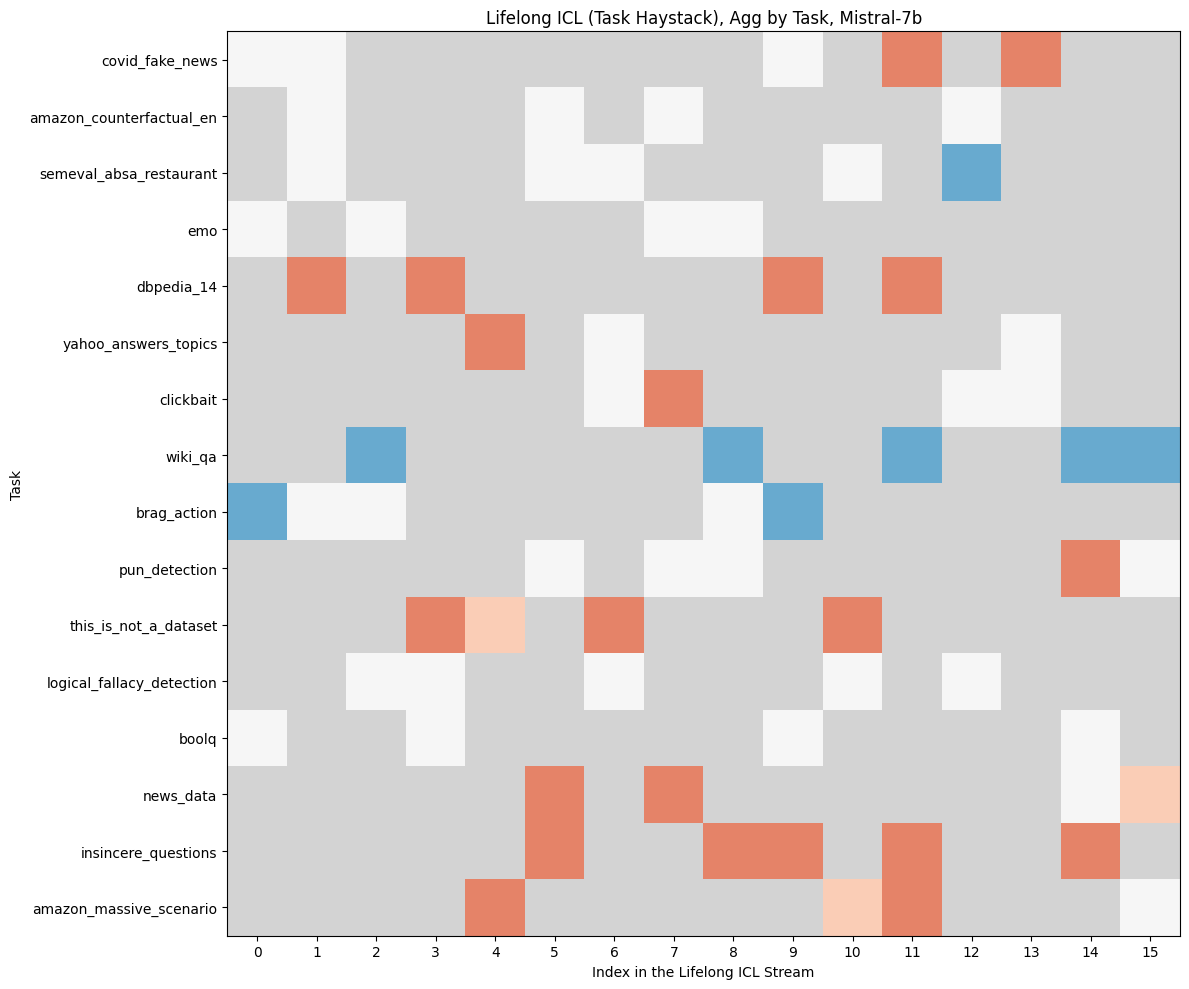

In [54]:

# Convert the dictionary to a list of lists
# Convert the dictionary to a list of lists and transpose it
data = avg_delta

matrix = np.array([final_agg[key] for key in final_agg])
masked_data = np.ma.masked_invalid(matrix)

# Plotting
plt.figure(figsize=(12, 10))

plt.imshow(matrix, cmap=cmap, aspect='auto', vmin=-1, vmax=1)

# Add color bar
# plt.colorbar(label='Accuracy Delta')

# Set tick labels
plt.yticks(np.arange(len(matrix)), list(data.keys()))
plt.xticks(np.arange(len(data)), range(len(data)))

# Set labels and title
plt.ylabel('Task')
plt.xlabel('Index in the Lifelong ICL Stream')
plt.title('Lifelong ICL (Task Haystack), Agg by Task, Mistral-7b')

plt.tight_layout()
plt.show()

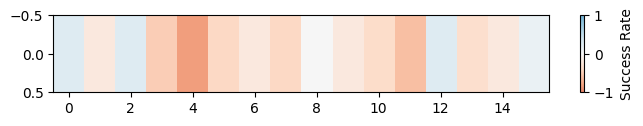

In [55]:
avg_for_idx = np.nanmean(matrix, axis=0)
plt.figure(figsize=(8, 1))
plt.imshow(avg_for_idx[np.newaxis,:], cmap=cmap, aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Success Rate')

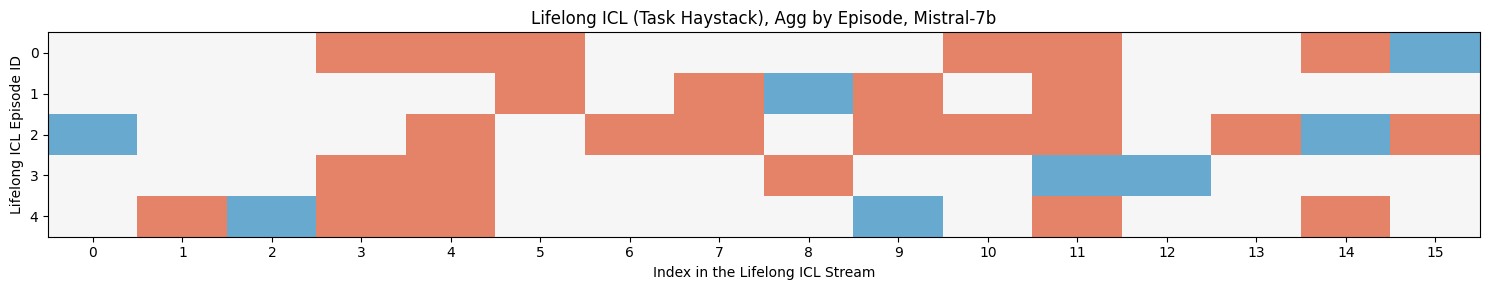

In [56]:

# Convert the dictionary to a list of lists
# matrix = [final_agg[key] for key in final_agg]
# Convert the dictionary to a list of lists and transpose it
matrix = np.array([episode_agg[key] for key in episode_agg])

# Plotting
plt.figure(figsize=(15, 3))


plt.imshow(matrix, cmap=cmap, aspect='auto', vmin=-1, vmax=1)

# Add color bar
# plt.colorbar(label='Accuracy Delta')

# Set tick labels
plt.yticks(np.arange(len(matrix)), list(episode_agg.keys()))
plt.xticks(np.arange(len(matrix[0])), range(len(matrix[0])))

# Set labels and title
plt.ylabel('Lifelong ICL Episode ID')
plt.xlabel('Index in the Lifelong ICL Stream')
plt.title('Lifelong ICL (Task Haystack), Agg by Episode, Mistral-7b')

plt.tight_layout()
plt.show()